**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../..')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train
from mrcnn.coco            import prep_coco_dataset, CocoConfig ## CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# def get_ax(rows=1, cols=1, size=16):
#     """Return a Matplotlib Axes array to be used in
#     all visualizations in the notebook. Provide a
#     central point to control graph sizes.
    
#     Adjust the size attribute to control how big to render images
#     """
#     _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
#     return ax


## Configurations

DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
# fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
 
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.VERBOSE              = 1
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'
fcn_config.display()

## Build FCN Model

with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN8', config=fcn_config)

fcn_model.keras_model.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/kbardool/models/train_fcn_coco

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN              

    old_style_scores               :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1_scattered         :  shape: (1, 81, 100, 3)       KB.shape:(1, 81, 100, 3)       Keras Tensor: False

       Normalize_scores() ------------------------------------------------------
         input shape      :  (1, 81, 100, 3)
         reduce_min shape :  (1, 81, 1, 3)
         reduce_max shape :  (1, 81, 1, 3)
             output shape :  (1, 81, 100, 3)

    alt_scores_1_norm(by_class)    :  shape: (1, 81, 100, 3)       KB.shape:(1, 81, 100, 3)       Keras Tensor: False
    alt_scores_1_norm(by_image)    :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False

    Normalize heatmap within each class !-------------------------------------
    in_heatmap_norm :  (?, 81, 256, 256) Keras tensor  False
    normal

## Set weight files

In [6]:
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181020T1506/fcn_0124.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181021T1602/fcn_0188.h5'
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181022T1622/fcn_0001.h5'

# DIR_WEIGHTS = '/home/kbardool/models/train_fcn_coco/fcn20181023T0825'
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181026T1432'

# filepath = os.path.join(DIR_WEIGHTS, 'fcn_init_weights')
# fcn_model.keras_model.save_weights(filepath, overwrite=True)
# fcn_model.save_model(DIR_WEIGHTS, 'fcn_init_weights')
# fcn_model.keras_model.summary()
##'fcn_init_weights.h5',
DIR_WEIGHTS =  'F:/models/train_fcn8_bce/fcn20181205T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# DIR_WEIGHTS =  '/home/kbardool/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
files   = ['fcn_0101.h5','fcn_0135.h5','fcn_0397.h5','fcn_0500.h5','fcn_0671.h5']

## Load Weights - 1

In [7]:
weights_path = os.path.join(DIR_WEIGHTS  , files[0])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0101.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0101.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0101.h5
    Weights file loaded: F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0101.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [8]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[0]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1270722747,+0.1412307173,+0.0421137251
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0361018144,+0.0252219662,+0.0111309877
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1377154440,+0.1279582232,+0.0438677147
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0285716020,+0.0273571871,+0.0089944070
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1197355688,+0.1994387358,+0.0357048810
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0409614407,+0.0071664657,+0.0076443134
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1238706037,+0.2116411328,+0.0306623764
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0307389237,+0.0299132559,+0.0068197423
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1005836874,+0.1246575117,+0.0254924595
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0332972258,+0.0288985539,+0.0089082252


In [ ]:
from mrcnn.utils import convertHtmlToPdf

### Histograms of Weights - 1st weight file

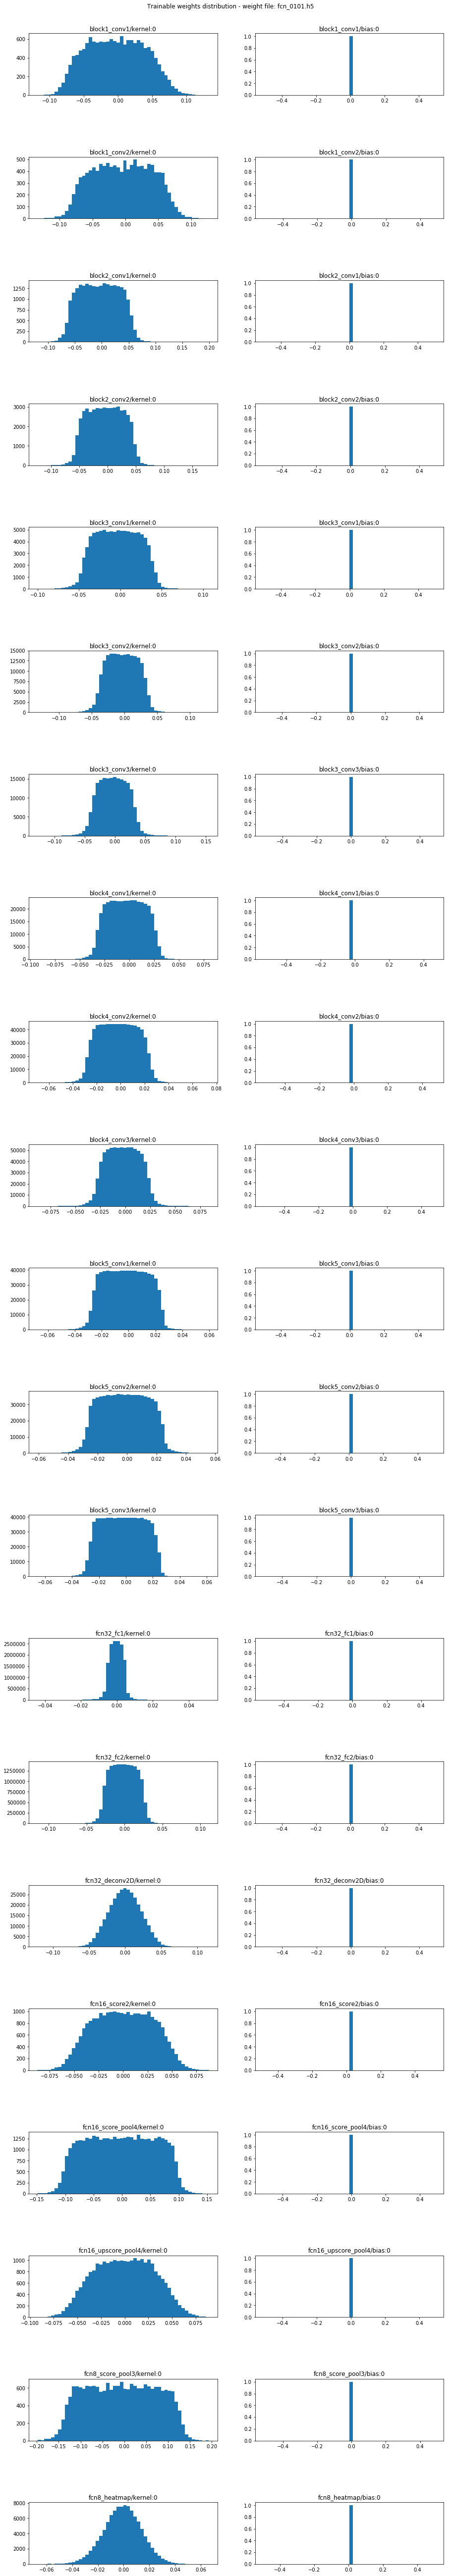

In [9]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[0])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[0]+'.png')
a.savefig(weights_histogram)

## Load Weights - 2

In [10]:
weights_path = os.path.join(DIR_WEIGHTS  , files[1])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0135.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0135.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0135.h5
    Weights file loaded: F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0135.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [11]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1516544968,+0.1377046108,+0.0426075570
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0306237582,+0.0237158481,+0.0110091818
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1453139037,+0.1269969791,+0.0445808358
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0289008953,+0.0245892704,+0.0110361846
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1217758432,+0.1925003827,+0.0363653973
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0430095233,+0.0090504894,+0.0097769750
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1266416162,+0.2063883394,+0.0311458763
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0295444354,+0.0267950725,+0.0074834717
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1138156727,+0.1260743886,+0.0259944052
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0399788208,+0.0256668590,+0.0103764813


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.1516544968</td><td>+0.1377046108</td><td>+0.0426075570</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0306237582</td><td>+0.0237158481</td><td>+0.0110091818</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1453139037</td><td>+0.1269969791</td><td>+0.0445808358</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0289008953</td><td>+0.0245892704</td><td>+0.0110361846</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.1217758432</td><td>+0.1925003827</td><td>+0.0363653973</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 2nd weights file

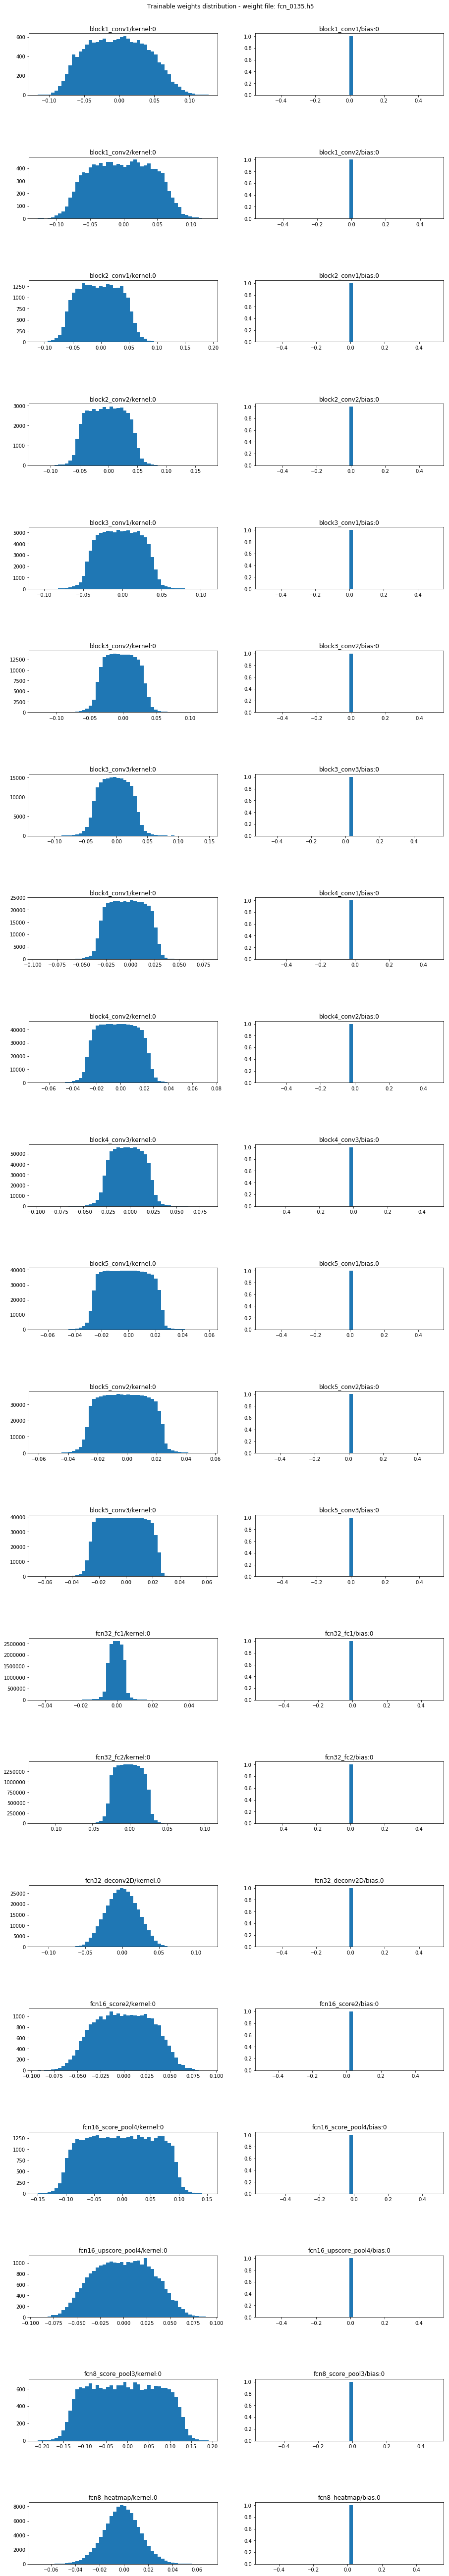

In [12]:
a = visualize.display_weight_histograms(fcn_model, filename = files[1])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[1]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [13]:
weights_path = os.path.join(DIR_WEIGHTS  , files[2])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0397.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0397.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0397.h5
    Weights file loaded: F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0397.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

In [14]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1730765253,+0.1561929286,+0.0441782027
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0425122827,+0.0266170949,+0.0135481479
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1547577232,+0.1594520062,+0.0456127897
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0299283173,+0.0235338733,+0.0132597145
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1303889006,+0.1826779991,+0.0377298556
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0524782985,+0.0139144333,+0.0140432278
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1278847754,+0.1975924075,+0.0323251002
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0323566645,+0.0220426079,+0.0104738828
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1374591887,+0.1237816289,+0.0274075568
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0508431979,+0.0260067079,+0.0132508436


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.1730765253</td><td>+0.1561929286</td><td>+0.0441782027</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0425122827</td><td>+0.0266170949</td><td>+0.0135481479</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1547577232</td><td>+0.1594520062</td><td>+0.0456127897</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0299283173</td><td>+0.0235338733</td><td>+0.0132597145</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.1303889006</td><td>+0.1826779991</td><td>+0.0377298556</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 3rd weight file

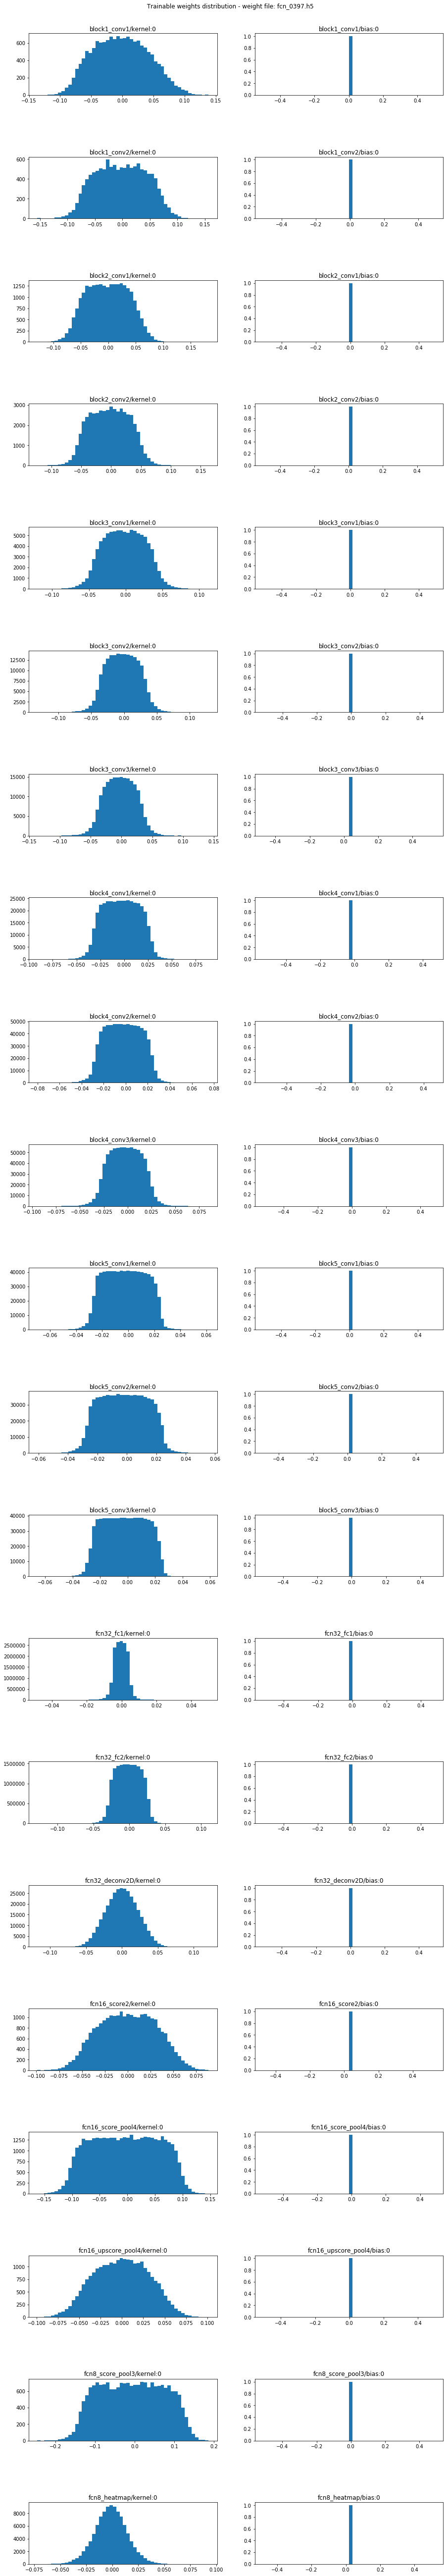

In [15]:
a = visualize.display_weight_histograms(fcn_model, filename = files[2])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [16]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0500.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0500.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0500.h5
    Weights file loaded: F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0500.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [18]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1763263196,+0.1632303596,+0.0447441749
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0429784022,+0.0277529079,+0.0142186731
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1620867401,+0.1726226956,+0.0459444970
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0325221568,+0.0215292778,+0.0143523086
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1355762482,+0.1779890060,+0.0381564870
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0612777099,+0.0141249979,+0.0157766715
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1317547411,+0.1941854507,+0.0326516069
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0369493663,+0.0209544823,+0.0116023887
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1490997970,+0.1245886758,+0.0277952235
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0571633838,+0.0267745648,+0.0139210168


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.1763263196</td><td>+0.1632303596</td><td>+0.0447441749</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0429784022</td><td>+0.0277529079</td><td>+0.0142186731</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1620867401</td><td>+0.1726226956</td><td>+0.0459444970</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0325221568</td><td>+0.0215292778</td><td>+0.0143523086</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.1355762482</td><td>+0.1779890060</td><td>+0.0381564870</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights

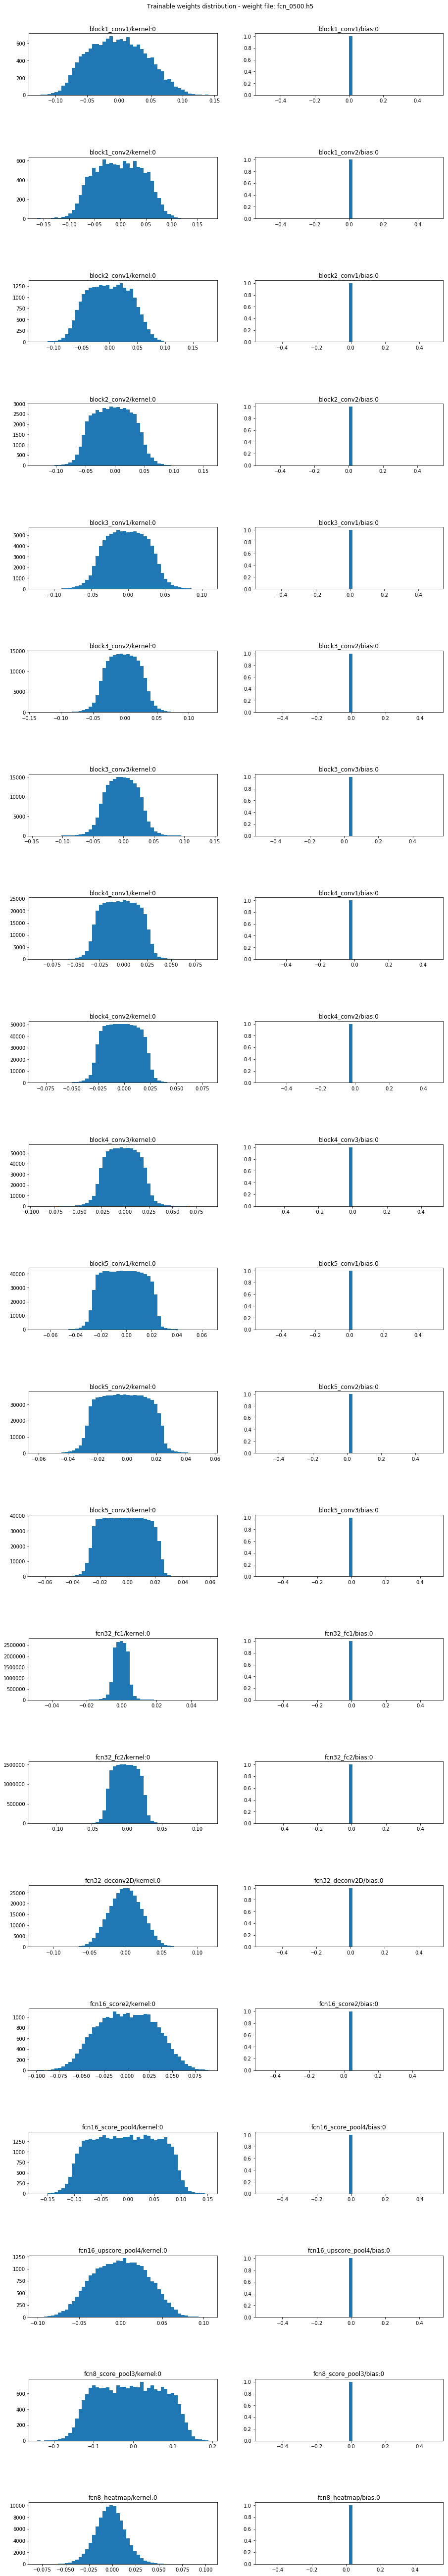

In [19]:
a = visualize.display_weight_histograms(fcn_model, filename = files[3])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [20]:
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0671.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0671.h5
    Weights file loaded: F:/models/train_fcn8_bce/fcn20181205T0000\fcn_0671.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [21]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.2023181766,+0.1668975502,+0.0453598239
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0477584638,+0.0256866589,+0.0144119812
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1699562073,+0.1757934988,+0.0463265367
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0366050377,+0.0212702956,+0.0155160120
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1393462718,+0.1725673229,+0.0386426188
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0650333539,+0.0137701640,+0.0165566448
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1448522210,+0.1832900345,+0.0330823623
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0357996114,+0.0198203996,+0.0128982179
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1584632695,+0.1266154200,+0.0282613728
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0630488619,+0.0266097020,+0.0149165690


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.2023181766</td><td>+0.1668975502</td><td>+0.0453598239</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0477584638</td><td>+0.0256866589</td><td>+0.0144119812</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1699562073</td><td>+0.1757934988</td><td>+0.0463265367</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0366050377</td><td>+0.0212702956</td><td>+0.0155160120</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.1393462718</td><td>+0.1725673229</td><td>+0.0386426188</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 5th weight file

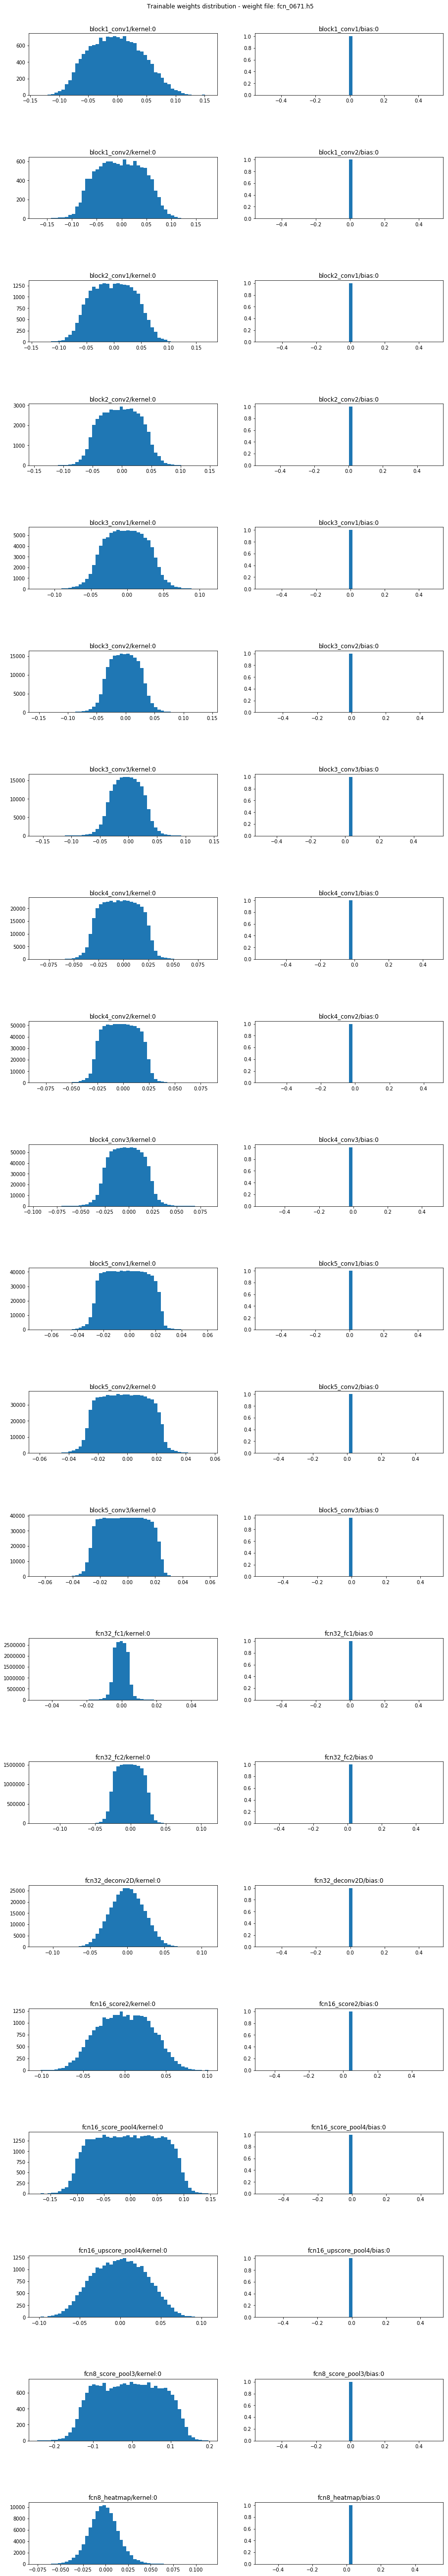

In [22]:
a = visualize.display_weight_histograms(fcn_model, filename = files[4])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [ ]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

### Review Weight Stats - 6th weight file

In [ ]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 6th weight file

In [ ]:
a = visualize.display_weight_histograms(fcn_model, filename = files[5])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [ ]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

### Review Weight Stats - 7th weight file

In [ ]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

### Histograms of Weights - 7th weight file

In [ ]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)